## Описание проекта: телекоммуникации
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Необходимо предсказать ухода клиента – отказ от продолжения пользования услугами, предоставляемыми заказчиком.
Основное пожелание заказчика – снизить убытки, связанные с неэффективными акциями по удержанию клиентов с помощью промо-купонов, скидок и прочих пакетов стимулирования.

Так, маркетологи компании выделяют две болевые точки:
<br /> 1) пользователю предложили промокоды, но он не собирался уходить (False Positive);
<br /> 2) пользователю ничего не предложили и он ушёл (False Negative).
<br /> После разработки модели заказчик хочет получить интерпретацию её работы (график ROC, матрица ошибок, важность признаков). 
- Основная метрика: ROC-AUC – для выдерживания баланса между false Positive и false Negative. 
- Дополнительная метрика: accuracy – для интерпретации (с матрицами ошибок).
- Минимальный порог хорошей модели: ROC-AUC >= 0.85

### Описание данных
Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

### План работы
1) составление описания проекта
2) обзор данных
3) предобработка данных
<br/> 3.1. изменение типов данных
<br/> 3.2. заполнение пропусков
<br/>3.3. составление новых признаков на основе имеющихся
4) исследование данных - составление корреляционой матрицы и анализ распредления важнейших для целевого показателя признаков 
5) отбросить неважные для моделей признаки на основе матрицы корреляции (тут вопрос: насколько низкой должна быть корреляция, чтобы мы могли судить о том, что признак не повлияет на результат модели)
6) разделение данных на тренировочную и тестовую выборки
7) кодирование категориальных значений + масштабирование данных
8) обучение моделей (логистическая регрессия, случайный лес, бустинг) с использованием гридсерча и пайплайна с указанием параметра class_weight=‘balanced’ 
9) выбор лучшей модели по метрике roc-auc, проверка только этой модели на тестовой выборке+проверка ее метрики "accuracy" 
10) интерпретация результатов: ROC-кривая, матрица ошибок, анализ важности признаков (анализ важности признаков, получается, несколько дублирует то, что мы делаем в EDA? там ведь тоже после матрицы корреляции изучали некоторые признаки)
11) составлене отчета

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as py
import sys
import plotly.express as px
import phik

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMRegressor

from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
try: 
    personal = pd.read_csv('/datasets/personal_new.csv')
    contract = pd.read_csv('/datasets/contract_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')
except:
    print('Вы работаете в другой среде')

In [6]:
def line():
    print('-'*60)
    
def inspection(data):
    print(data.head())
    line()
    print(data.info())

state = 140823

In [7]:
inspection(personal)

   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


In [8]:
inspection(contract)

   customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        31.04  
1               Mailed check           56.95      2071.84  
2               Mailed check           53.85       226.17  
3  Bank transfer (automatic)           42.30       1960.6  
4           Electronic check           70.70        353.5  
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  

In [9]:
inspection(internet)

   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No  
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   cus

In [10]:
inspection(phone)

   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


In [11]:
personal = personal.set_index('customerID')
internet = internet.set_index('customerID')
contract = contract.set_index('customerID')
phone = phone.set_index('customerID')

data = personal.join([internet, contract, phone])

In [12]:
inspection(data)

            gender  SeniorCitizen Partner Dependents InternetService  \
customerID                                                             
7590-VHVEG  Female              0     Yes         No             DSL   
5575-GNVDE    Male              0      No         No             DSL   
3668-QPYBK    Male              0      No         No             DSL   
7795-CFOCW    Male              0      No         No             DSL   
9237-HQITU  Female              0      No         No     Fiber optic   

           OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
customerID                                                            
7590-VHVEG             No          Yes               No          No   
5575-GNVDE            Yes           No              Yes          No   
3668-QPYBK            Yes          Yes               No          No   
7795-CFOCW            Yes           No              Yes         Yes   
9237-HQITU             No           No               No          No  

Итак, у нас есть датасет на 7043 строк. Для предобработки датасета треубется выполнить следующее:
- изменить формат данных в признаках связанных с датами (BeginDate, EndDate) и в столбце TotalCharge (изменить на float)
- cформировать новый признак "количество дней/недель/месяцев от начала контракта" (сегодня 01.02.2020), а BeginDate и EndDate в последтвии удалить 
- выделить целевой признак из EndDate (есть дата -> таргет=1, если нет, то таргет=0)
- во всех столбцах, которые относятся к интернету, пропуски заполнить на "no_internet", так как клиенты, видимо, не пользовались услугами интернета
- во всех столбцах, которые относятся к телефонии пропуски заполнить на "no_phone"  так как клиенты, видимо, не пользовались услугами телефонии
- создать два отдельных признака, с информацией о том, какой услугой пользуется клиент: например, признаки "Internet" и "Phone" с Yes/Nо в качестве данных



In [14]:
#сразу выделим целевой признак
def target(enddate):
    if enddate == 'No':
        return 0
    else:
        return 1

data['target'] = data['EndDate'].apply(target)
data.loc[data['target']==0].head()

,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,target
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,NaN,0
5575-GNVDE,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,No,0
3668-QPYBK,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,No,0
7795-CFOCW,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,NaN,0
9237-HQITU,Female,0,No,No,Fiber optic,No,No,No,No,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,No,0


In [15]:
#займемся сначала врременны'ми признаками
data['BeginDate'] = pd.to_datetime(data['BeginDate'],format='%Y-%m-%d')
data['EndDate'] = pd.to_datetime(data['EndDate'], errors='coerce', format='%Y-%m-%d')

In [16]:
data[['EndDate','target']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   EndDate  1101 non-null   datetime64[ns]
 1   target   7043 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 165.1+ KB


In [17]:
data['EndDate'] = data['EndDate'].fillna('2020-02-01')
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d')

In [18]:
data['duration'] = (data['EndDate'] - data['BeginDate']).dt.days

In [19]:
inspection(data[['BeginDate', 'EndDate', 'duration', 'target']])

            BeginDate    EndDate  duration  target
customerID                                        
7590-VHVEG 2020-01-01 2020-02-01        31       0
5575-GNVDE 2017-04-01 2020-02-01      1036       0
3668-QPYBK 2019-10-01 2020-02-01       123       0
7795-CFOCW 2016-05-01 2020-02-01      1371       0
9237-HQITU 2019-09-01 2020-02-01       153       0
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   BeginDate  7043 non-null   datetime64[ns]
 1   EndDate    7043 non-null   datetime64[ns]
 2   duration   7043 non-null   int64         
 3   target     7043 non-null   int64         
dtypes: datetime64[ns](2), int64(2)
memory usage: 275.1+ KB
None


In [20]:
#удалим ненужные теперь данные
data.drop(['EndDate', 'BeginDate'], axis=1, inplace=True)

In [21]:
#Добавил мои рассуждения и строку с проверкой уникальных категориальных значений в столбцах связанных с интернетом
for i in internet.columns:
    print(i, internet[i].unique())

InternetService ['DSL' 'Fiber optic']
OnlineSecurity ['No' 'Yes']
OnlineBackup ['Yes' 'No']
DeviceProtection ['No' 'Yes']
TechSupport ['No' 'Yes']
StreamingTV ['No' 'Yes']
StreamingMovies ['No' 'Yes']


Видим, что в столбцах, связанных с интернетом не так много категориальных значений, в 6 из 7 из них булевы значения. соответсвенно, можем заполнить пропуски в данных слобцах заглушкой 'no_internet', так как логически она пбудет соответствовать данным - клиент скорее всего попросту не пользуется интернетом, а использует только телефонию.

In [22]:
#заполним пропуски в стобцах, связанных с интернетом
for i in internet.columns:
        data[i] = data[i].fillna('no_internet')

In [23]:
for i in phone.columns:
    print(i, phone[i].unique())

MultipleLines ['No' 'Yes']


In [24]:
#аналогично интернету заполним пропуски в стобцах, связанных с телефонией
data['MultipleLines'] = data['MultipleLines'].fillna('no_phone')

In [25]:
#создадим доп прзнаки
data['internet'] ='Yes'
data.loc[(data.InternetService == 'no_internet'), 'internet'] = 'No'

data['phone'] ='Yes'
data.loc[(data.MultipleLines == 'no_phone'), 'phone'] = 'No'

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   InternetService   7043 non-null   object 
 5   OnlineSecurity    7043 non-null   object 
 6   OnlineBackup      7043 non-null   object 
 7   DeviceProtection  7043 non-null   object 
 8   TechSupport       7043 non-null   object 
 9   StreamingTV       7043 non-null   object 
 10  StreamingMovies   7043 non-null   object 
 11  Type              7043 non-null   object 
 12  PaperlessBilling  7043 non-null   object 
 13  PaymentMethod     7043 non-null   object 
 14  MonthlyCharges    7043 non-null   float64
 15  TotalCharges      7043 non-null   object 
 16  MultipleLines     7043 non-null 

In [27]:
def convert_float(cell):
    try:
        return float(cell)
    except:
        return None
data['TotalCharges'] = data['TotalCharges'].apply(convert_float)

In [28]:
data[['TotalCharges', 'Dependents']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TotalCharges  7032 non-null   float64
 1   Dependents    7043 non-null   object 
dtypes: float64(1), object(1)
memory usage: 165.1+ KB


In [29]:
data['TotalCharges'] = data['TotalCharges'].fillna(0)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   InternetService   7043 non-null   object 
 5   OnlineSecurity    7043 non-null   object 
 6   OnlineBackup      7043 non-null   object 
 7   DeviceProtection  7043 non-null   object 
 8   TechSupport       7043 non-null   object 
 9   StreamingTV       7043 non-null   object 
 10  StreamingMovies   7043 non-null   object 
 11  Type              7043 non-null   object 
 12  PaperlessBilling  7043 non-null   object 
 13  PaymentMethod     7043 non-null   object 
 14  MonthlyCharges    7043 non-null   float64
 15  TotalCharges      7043 non-null   float64
 16  MultipleLines     7043 non-null 

In [31]:
data[['MonthlyCharges', 'TotalCharges', 'duration']].describe()

,MonthlyCharges,TotalCharges,duration
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,898.555729
std,30.090047,2112.742814,683.130510
min,18.250000,0.000000,0.000000
25%,35.500000,436.750000,276.000000
50%,70.350000,1343.350000,761.000000
75%,89.850000,3236.690000,1461.000000
max,118.750000,9221.380000,2314.000000


1) Данные обработаны, из нашего и так небольшого датафрейма не было удалено ни одной строки. 
2) Пропуски были заполнены заглушками (в столбцах по интернету и телефонии) и нулями в столбце TotalCharges. 
3) Было добавлено 3 новых признака (duration, internet, phone) и выделен целевой (target). 

Далее проведем анализ корреляции признаков с целевым, и рассмотри распределение значений данных признаков.

## EDA

In [32]:
interval_cols = ['duration', 'MonthlyCharges', 'TotalCharges']
phik_overview = data.phik_matrix(interval_cols=interval_cols)
phik_overview.style.background_gradient('Set1_r')

,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,target,duration,internet,phone
gender,1.000000,0.000000,0.000000,0.000000,0.000000,0.001460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008175,0.000000,0.000000,0.008581,0.000000,0.000000,0.000000
SeniorCitizen,0.000000,1.000000,0.016992,0.324576,0.160702,0.127319,0.109995,0.110177,0.135283,0.111714,0.113778,0.086231,0.242133,0.292725,0.304985,0.135650,0.087925,0.086159,0.063315,0.281853,0.000000
Partner,0.000000,0.016992,1.000000,0.652122,0.000000,0.091202,0.092012,0.100092,0.076326,0.082251,0.077506,0.179736,0.013218,0.243008,0.203545,0.381958,0.086249,0.226688,0.453688,0.000000,0.019540
Dependents,0.000000,0.324576,0.652122,1.000000,0.108463,0.117219,0.097766,0.094597,0.109753,0.088193,0.084684,0.147680,0.172593,0.224903,0.184366,0.084247,0.011198,0.046871,0.198729,0.216514,0.000000
InternetService,0.000000,0.160702,0.000000,0.108463,1.000000,0.949498,0.942842,0.942811,0.948914,0.946713,0.946294,0.505187,0.231438,0.323886,0.919002,0.490081,0.739808,0.056621,0.060845,1.000000,0.278954
OnlineSecurity,0.001460,0.127319,0.091202,0.117219,0.949498,1.000000,0.947224,0.946787,0.952651,0.943082,0.943248,0.636884,0.208320,0.315799,0.812632,0.516538,0.540261,0.058659,0.346398,1.000000,0.106021
OnlineBackup,0.000000,0.109995,0.092012,0.097766,0.942842,0.947224,1.000000,0.947487,0.947756,0.945789,0.945395,0.581660,0.195321,0.293413,0.818851,0.550544,0.562933,0.089704,0.366170,1.000000,0.103910
DeviceProtection,0.000000,0.110177,0.100092,0.094597,0.942811,0.946787,0.947487,1.000000,0.950247,0.952863,0.953717,0.631531,0.195687,0.297923,0.827272,0.558393,0.564610,0.085608,0.374702,1.000000,0.103604
TechSupport,0.000000,0.135283,0.076326,0.109753,0.948914,0.952651,0.947756,0.950247,1.000000,0.946393,0.946417,0.671629,0.200621,0.317713,0.816660,0.527838,0.541088,0.051537,0.353438,1.000000,0.106451
StreamingTV,0.000000,0.111714,0.082251,0.088193,0.946713,0.943082,0.945789,0.952863,0.946393,1.000000,0.965306,0.549564,0.204717,0.284531,0.864677,0.555322,0.586049,0.078545,0.306675,1.000000,0.108565


Наибольшее влияние на целевой признак оказывают столбцы partner, PaymentMethod, MonthlyCharges, TotalCharges, duration, Рассмотрим распределение их значений относительно целевого признака подробнее.

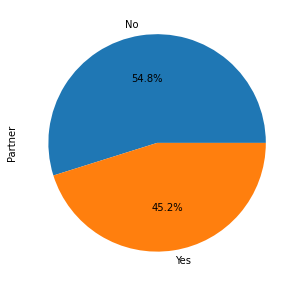

In [33]:
data[data['target'] == 0]['Partner'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5, 5))
plt.show()

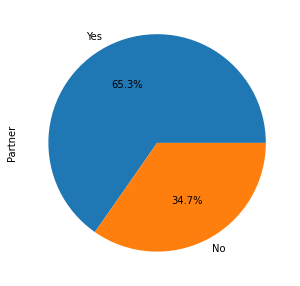

In [34]:
data[data['target'] == 1]['Partner'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5, 5))
plt.show()

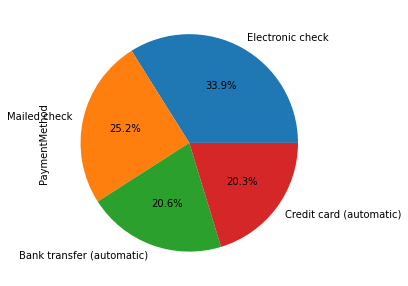

In [35]:
data[data['target'] == 0]['PaymentMethod'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5, 5))
plt.show()

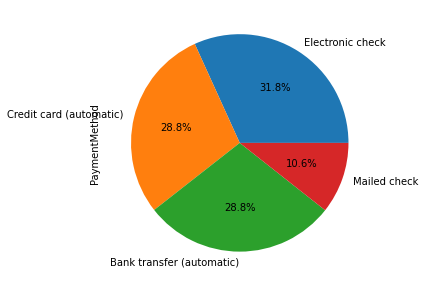

In [36]:
data[data['target'] == 1]['PaymentMethod'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5, 5))
plt.show()

Итак, мы видим, что наличие партнера больше характерно для клиентов, которые уже не пользуются услугами оператора связи «Ниединогоразрыва.ком». Так же можно заметить, что Electronic Check самы популярный способ опалты у обеих групп клиентов, однако остальные значения данного признака разняться: у бывших клиентов способ оплаты credit card (automatic) является таким же популярным как и bank transfer, в то время как у нынешних клиентов наиболее популярен  способ оплаты через mailed check. 

Оператору связи стоит обратить внимание на эту закономерность и разобрать преимущества и недостатки для их клиентов различных способах оплаты (особенно пристально советую рассмотреть mailed check.

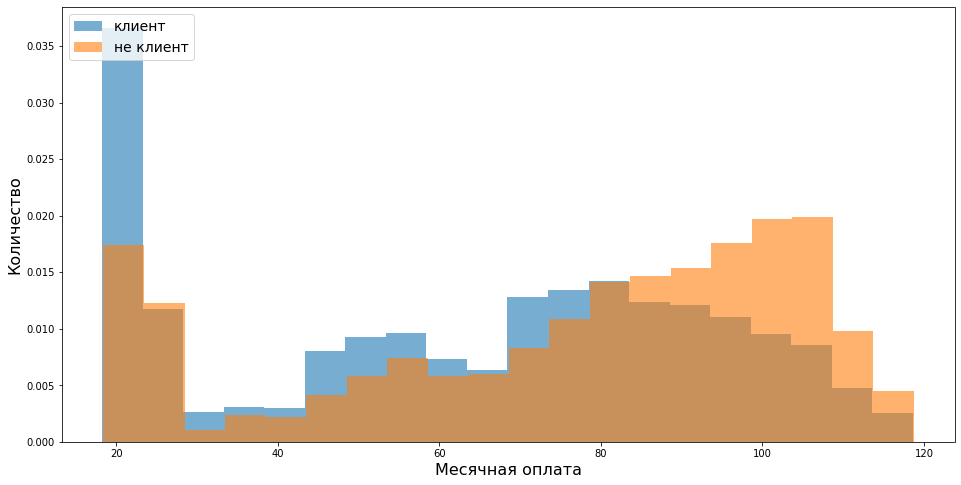

In [37]:
plt.figure(figsize=(16,8))
plt.hist(x = data[data['target'] == 0]['MonthlyCharges'],alpha=.6, density = True, bins=20, label='клиент')
plt.hist(x = data[data['target'] == 1]['MonthlyCharges'],alpha=.6, density = True, bins=20, label='не клиент')
plt.legend(loc = 'upper left', prop = {'size': 14})
plt.xlabel('Месячная оплата', fontsize = 16)
plt.ylabel('Количество', fontsize = 16)
plt.show()

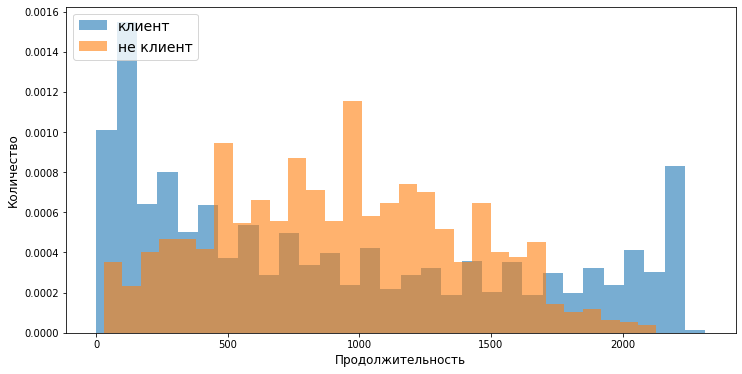

In [38]:
plt.figure(figsize=(12,6))
plt.hist(x = data[data['target'] == 0]['duration'],alpha=.6, density = True, bins=30, label='клиент')
plt.hist(x = data[data['target'] == 1]['duration'],alpha=.6, density = True, bins=30, label='не клиент')
plt.legend(loc = 'upper left', prop = {'size': 14})
plt.xlabel('Продолжительность', fontsize = 12)
plt.ylabel('Количество', fontsize = 12)
plt.show()

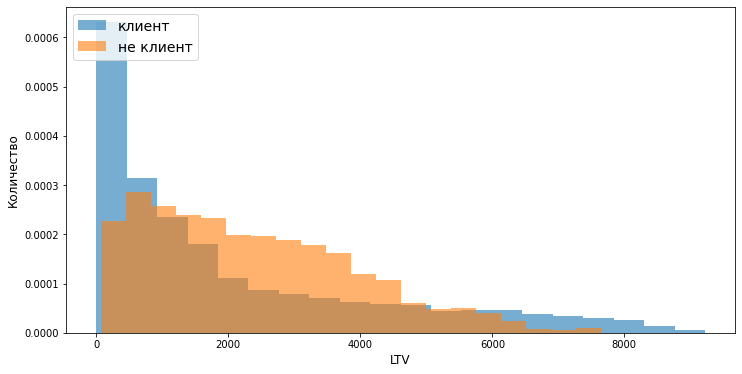

In [39]:
plt.figure(figsize=(12,6))
plt.hist(x = data[data['target'] == 0]['TotalCharges'],alpha=.6, density = True, bins=20, label='клиент')
plt.hist(x = data[data['target'] == 1]['TotalCharges'],alpha=.6, density = True, bins=20, label='не клиент')
plt.legend(loc = 'upper left', prop = {'size': 14})
plt.xlabel('LTV', fontsize = 12)
plt.ylabel('Количество', fontsize = 12)
plt.show()

Рассматривая распределение платы за месяц можно заметить что у нынешних клиентов плата за месяц меньше чем у тех, что престали таоквыми быть, что может быть связано как с уменьшением количества испольуемых услуг, так и с понижением цен. 
<br />По графику распределения продолжительности пользования услугами оператора связи можно сделать вывод о том, что распределение стало менее нормальным, нежели было до этого,то же самое можно сказать и об LTV.

Отбросим 3 наименее коррелирующи с таргетом признаков и обучим модели

In [40]:
data.drop(['phone', 'gender', 'Dependents'], axis=1, inplace=True)

Так же отбросим некоторые мультиколлинеарные столбцы с информацией об интернет-услугах

In [41]:
data.drop(['OnlineSecurity', 'OnlineBackup', 
           'DeviceProtection', 'TechSupport', 
           'StreamingTV', 'StreamingMovies', 'InternetService'], axis=1, inplace=True)

## Предобработка для подачи в модель

In [42]:
data['target'].value_counts()

0    5942
1    1101
Name: target, dtype: int64

 Мы видим, что присутствует достаточно большой дисбаланс классов,его необходимо будет убрать, иначе модель будет плохо распознавать класс с меньшим количеством наблюдений (в данном случае - класс с меткой 1). Наилучший для этого способ в нашем случае - указание гипперпараметра class_weight.

In [43]:
#выделим целевой признак, категориальные признаки, разобьем на две выборке 1 к 3
features = data.drop('target', axis=1)
target = data['target']

#определим категориальные признаки, числовые уже заданы в переменной interval_cols
cat_features = features.drop(interval_cols, axis=1).columns.tolist()

#разобьем на две выборке 1 к 3
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, stratify=target, random_state=state)

Создадим переменные для встраиванием их в пайплайн обучения моделей.

In [44]:
num_transformer = StandardScaler() #масштабирование численных
cat_transformer = OneHotEncoder(handle_unknown ='error', drop='first')
cat_transformer_der = OrdinalEncoder(handle_unknown ='use_encoded_value', unknown_value=-1)

In [45]:
#cоздадим ColumnTransformer'ы
preprocessor_linear = ColumnTransformer(transformers=[
    ('num', num_transformer, interval_cols),
    ('cat', cat_transformer, cat_features)])

preprocessor_forest = ColumnTransformer(transformers=[
    ('num', num_transformer, interval_cols),
    ('cat', cat_transformer_der, cat_features)])

preprocessor_catboost = ColumnTransformer(transformers=[
    ('num', num_transformer, interval_cols)], remainder='passthrough')

## Обучение моделей

### Случайный лес

In [46]:
forest_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor_forest),
    ('classifier', RandomForestClassifier(random_state=state))])

forest_param= {
    'classifier__n_estimators': [50, 100, 150, 300],
    'classifier__max_depth': [10, 20, 30],
    'classifier__criterion': ['gini', 'entropy', 'log_loss']}

forest_grid = GridSearchCV(forest_pipe, forest_param, cv=5, scoring='roc_auc', n_jobs=-1)
forest_grid.fit(features_train, target_train)

print(f'RandomForest лучшие параметры: {forest_grid.best_params_}')
print(f'RandomForest лучшая оценка: {forest_grid.best_score_}')

RandomForest лучшие параметры: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__n_estimators': 300}
RandomForest лучшая оценка: 0.8339354094579452


### Лин. регрессия

In [47]:
linear = Pipeline(steps=[
    ('preprocessor', preprocessor_linear),
    ('classifier', LogisticRegression(random_state=state))])

linear_param = {
    'classifier__penalty': ['l1', 'l2','elasticnet'],
    'classifier__C': [0.1, 0.5, 1.0],
    'classifier__solver': ['liblinear'],
    'classifier__class_weight': ['balanced']}

linear_grid = GridSearchCV(linear, linear_param, cv=5, scoring='roc_auc', n_jobs=-1)
linear_grid.fit(features_train, target_train)

print(f'LogisticRegression лучшие параметры: {linear_grid.best_params_}')
print(f'LogisticRegression лучшая оценка: {linear_grid.best_score_}')

LogisticRegression лучшие параметры: {'classifier__C': 0.5, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
LogisticRegression лучшая оценка: 0.7658574902724978


### Cat Boost Classifier

In [48]:
catboost = CatBoostClassifier(random_state=state, verbose=False, cat_features=cat_features)

cat_param = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]}

cat_grid = GridSearchCV(catboost, cat_param, cv=5, error_score='raise', scoring='roc_auc', n_jobs=-1)
cat_grid.fit(features_train, target_train)

print(f'CatBoost лучшие параметры: {cat_grid.best_params_}')
print(f'CatBoost лучшая оценка: {cat_grid.best_score_}')

CatBoost лучшие параметры: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
CatBoost лучшая оценка: 0.8874043642638011


По результатам обучения моделей наилучший результат показала модель бустинга (CatBoost Classifier с параметрами 'depth': 6, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1) с результатом roc-auc 0,8874, что является выше целевого показателя. <br/>Остановимся на ней и проверим ее на тестовой выборке.

## Проверка лучшей модели на тестовой выборке

In [49]:
best_model = cat_grid.best_estimator_

preds = best_model.predict(features_test)
accuracy = accuracy_score(target_test, preds)


probabilities_test = best_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(f'Точность на тестовой выборке: {accuracy:.4f}')
print(f'ROC-AUC лучшей модели: {auc_roc:.4f}')

Точность на тестовой выборке: 0.8915
ROC-AUC лучшей модели: 0.8856


Модель показала accuracy (точность) 89%, другими словами наша модель примерно в 9 из 10 случаев корректно предсказала, останется ли клиент в компании, или нет. Вычисленный уровень метрики соответствует запросы данному заказчиком, кроме того показатель не является слишком выосоким, что бы говорило об утечке целевого признака в данных и переобучении модели. Уровень ROC-AUC лучшей модели: 0.8856, что также выше целевого показателя
## Интерпретация результатов
<br />Рассматорим матрицу ошибок и наиболее важные признаки для модели, что поможет заказчику наиболее точно интерпретировать результат и в будущем построить акции по удержанию клиента, нацеленные на влияние именно на эти признаки:

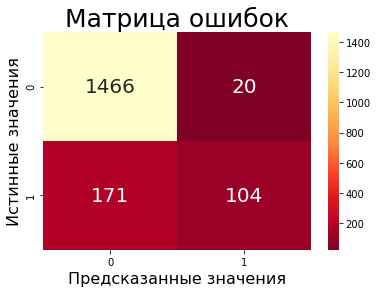

In [50]:
conf_matrix = confusion_matrix(target_test, preds)

sns.heatmap(conf_matrix, annot=True, fmt='d',annot_kws={"fontsize":20}, cmap='YlOrRd_r')
plt.ylabel('Истинные значения', fontsize=16)
plt.xlabel('Предсказанные значения', fontsize=16)
plt.title('Матрица ошибок', fontsize=25)
plt.show()

In [51]:
target_test.value_counts()

0    1486
1     275
Name: target, dtype: int64

По матрице ошибок можно сделать следующие выводы:
 модель достаточно хорошо распознает True Negative - клиентов, кто не собирается уходить от оператор связи "Ниединогоразрыва.ком", однако плохо справляется True Positive значениями, теми, кто скорее всего уйдет, 171 клиента из 104 она определила как клиента, который не собиарется уходить. Подобная плохая метрика True Positive скорее всего из-за того, что выборки не сбалансированы

- Попытался сбалансировать с помощью кода, который нашел на stackoverflow, однока метрики roc-auc и fccuracy упали ниже пороговых и я отказался от этой затеи (код ниже в формате markdown)

from sklearn.utils.class_weight import compute_class_weight
import numpy as np 

classes = np.unique(target_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target_train)
class_weights = dict(zip(classes, weights))

catboost_balanced = CatBoostClassifier(random_state=state, verbose=False, class_weights=class_weights, cat_features=cat_features)

cat_param = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]}

cat_grid_2 = GridSearchCV(catboost_balanced, cat_param, cv=5, error_score='raise', scoring='roc_auc', n_jobs=-1)
cat_grid_2.fit(features_train, target_train)

print(f'CatBoost лучшие параметры: {cat_grid_2.best_params_}')
print(f'CatBoost лучшая оценка: {cat_grid_2.best_score_}')

#CatBoost лучшие параметры: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
#CatBoost лучшая оценка: 0.8772144225750033

best_model_2 = cat_grid_2.best_estimator_

preds_2 = best_model_2.predict(features_test)
accuracy_2 = accuracy_score(target_test, preds_2)

print(f'Точность на тестовой выборке: {accuracy_2:.4f}')
print(f'ROC-AUC лучшей модели: {cat_grid_2.best_score_:.4f}')

#Точность на тестовой выборке: 0.8160
#ROC-AUC лучшей модели: 0.8772

onf_matrix = confusion_matrix(target_test, preds_2)

sns.heatmap(conf_matrix, annot=True, fmt='d',annot_kws={"fontsize":20}, cmap='YlOrRd_r')
plt.ylabel('Истинные значения', fontsize=16)
plt.xlabel('Предсказанные значения', fontsize=16)
plt.title('Матрица ошибок', fontsize=25)
plt.show()

#![Unknown.png](attachment:Unknown.png)

In [52]:
f_importance = pd.Series(best_model.get_feature_importance(),
                         features_train.columns)

In [53]:
f_importance.sort_values(ascending=False)

duration            44.273799
MonthlyCharges      12.229614
Type                11.373448
TotalCharges         9.304581
PaymentMethod        7.144857
MultipleLines        5.975249
Partner              4.033435
internet             2.772342
PaperlessBilling     1.649838
SeniorCitizen        1.242837
dtype: float64

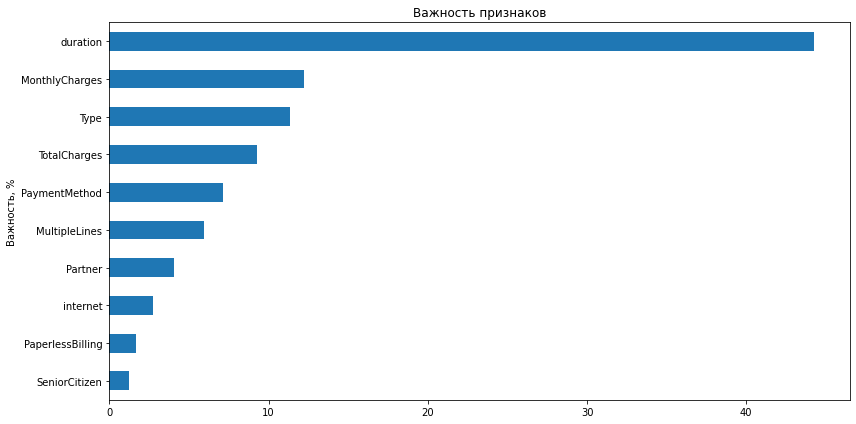

In [54]:
fig, ax = plt.subplots(figsize=(12,6))
f_importance.sort_values().plot.barh(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

Самым значимым признаком для модели, оказались количество проведённых клиентом дней в компании. Вторым по важности фактором является то, сколько клиент тратит на услуги ежемесячно и тип договора: ежемесячный, годовой и т.д. Наименее важными признаками оказались Наличие у клиента пенсионного статуса, факт выставления счёта по электронной почте. 

Text(0.5, 1.0, 'ROC-кривая')

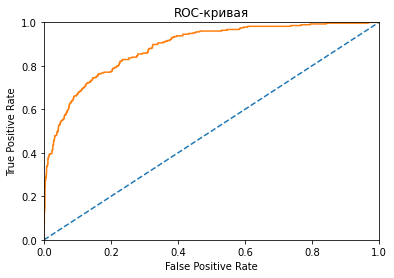

In [55]:
probabilities_test = best_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

Рок-кривая отличается от Рок-кривой случайной модели и изгибается ближе к левому верхнему углу -> качество модели лучше случайной и она является адекватной.

## Отчет
Целью работы является  предсказать ухода клиента – отказ от продолжения пользования услугами, предоставляемыми заказчиком.
Основное пожелание заказчика – снизить убытки, связанные с неэффективными акциями по удержанию клиентов с помощью промо-купонов, скидок и прочих пакетов стимулирования.

Работа была выполнена в соответствии с ранее обозначиным планом, ни один этап не был пропущен:

### **Предобработка**:
- путем объединения 4 таблиц получили датасет на 7043 строк. 
- изменены форматы данных в столбцах TotalCharge, BeginDate, EndDate
- заполнены пропуски в категориальных призанаках "заглушкой" no_intenet и no_phone (в стобцах связанных с интернетом и с телефонией соответственно)
- cформированы новые признаки с информацией о количестве дней от начала контракта (duration), и о том, какой услугой пользуется клиент: признаки "Internet" и "Phone" с Yes/Nо в качестве данных

**Вывод по этапу работы**: оператору стоить обратить внимание на форматы данных, в которых они записываются, в будущем это может помочь их собственным аналитикам в построении отчетов и анализе поступающей информации. 

### **EDA**:
- после построяния корреляционной матрицы проанализировано распределение наиболее коррелирующих с целевым признаком признаков и сделаны слудющие выводы: 
- на основе матрицы корреляции перед подачей в модель были удалены мультиколлинеарные признаки (что в будущем позитивно повлияло на предсказания модели): 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'InternetService'
- отброшены наименее коррелирующие признаки с целевой переменной, так как: 'phone', 'gender', 'Dependents'

**Вывод по этапу работы**: оператору стоит рассмотреть сбор другой, новой инофрмации о клиентах, для формаирования еще большего количества признаков для улучшения качества будущей модели. Кроме того в будущем стоит предоставить больше информации о тех клиентах, которые уже ушли от заказчика (на данный момент, подобных записй крайне мало).
Так же ниже представлено анализ распределения наиболее коррелирующих признаков с целевым: 

**1)** Наличие партнера больше характерно для клиентов, которые уже не пользуются услугами оператора связи «Ниединогоразрыва.ком». Так же можно заметить, что Electronic Check самы популярный способ оплаты у обеих групп клиентов, однако остальные значения данного признака разняться: у бывших клиентов способ оплаты credit card (automatic) является таким же популярным как и bank transfer, в то время как у нынешних клиентов наиболее популярен  способ оплаты через mailed check. 
  <br />  Оператору связи стоит обратить внимание на эту закономерность и разобрать преимущества и недостатки для их клиентов различных способах оплаты (особенно пристально советую рассмотреть mailed check.
<br />  **2)** Рассматривая распределение платы за месяц можно заметить что у нынешних клиентов плата за месяц меньше чем у тех, что престали таоквыми быть, что может быть связано как с уменьшением количества испольуемых услуг, так и с понижением цен. По графику распределения продолжительности пользования услугами оператора связи можно сделать вывод о том, что распределение стало менее нормальным, нежели было до этого,то же самое можно сказать и об LTV.


### **Обучение моделей**:
- на кросс-валидации было обучено 3 модели: линеная регрессия, случайный лес, catboost

In [56]:
df = pd.DataFrame({'model': ['RandomForest', 'LogisticRegression', 'CatBoostClassifier'], 
                   'auc-roc': [0.8339, 0.7658, 0.8840]})
df

,model,auc-roc
0,RandomForest,0.8339
1,LogisticRegression,0.7658
2,CatBoostClassifier,0.8840


- наилучший результат показала модель бустинга. При ее обучении были подобраны следующие гипперпараметры: 'iterations', 'learning_rate', 'depth' и 'l2_leaf_reg'. 
<br /> Наилучший результат roc_auc на тренировочной выборке равныый 0.8874 данная модель показала при следующих значениях гипперпараметров: 'depth': 6, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1.
<br />Эта же модель при тестировании на новой для нее тестовой выборке показала результат roc_auc равный 0.8874 и accuracy= 0.8915.
- В последствии были проанализированы матрица ошибок, рассмотрены наиболее значимые для модели признаки, построена roc-кривая.

**Вывод по этапу работы**: При анализе значимостипризнаков самым важным признаком для модели, оказалось количество проведённых клиентом дней в компании. Вторым по важности фактором является то, сколько клиент тратит на услуги ежемесячно и тип договора: ежемесячный, годовой и т.д. Наименее важными признаками являются наличие у клиента пенсионного статуса, факт выставления счёта по электронной почте. 



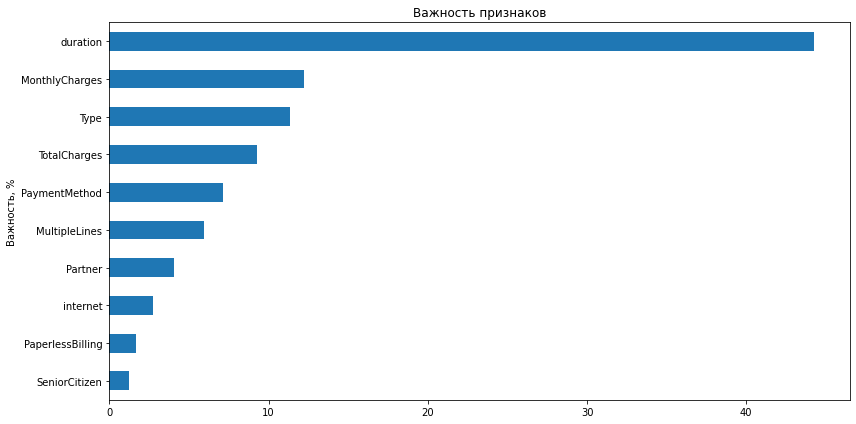


По матрице ошибок можно сделать следующие выводы:
 модель достаточно хорошо распознает True Negative - клиентов, кто не собирается уходить от оператор связи "Ниединогоразрыва.ком", однако плохо справляется True Positive значениями, теми, кто скорее всего уйдет, 171 клиента из 104 она определила как клиента, который не собиарется уходить. Подобная плохая метрика True Positive скорее всего из-за того, что выборки не сбалансированы
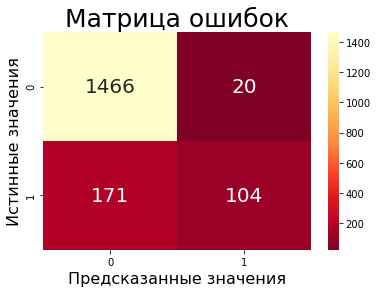

ROC-кривая: отличается от Рок-кривой случайно модели и изгибается ближе к левому верхнему углу -> модель предсказывает лучше случайная и является адекватной.

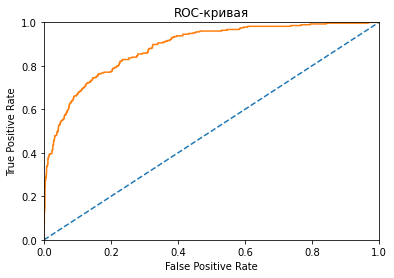

### Общий вывод по работе

Была проведена предобработка датасета на 7043 строк, удалены лишний признаки для подачи в модель. После обучения на кросс-валидации 3-х моделей наилучшей оказалась модель CatBoostClassifier, показавшая результат выше указанных заказчиком метрик.

В работе я столкнулся со следующими затруднениями: 
- новая для меня обертка для предобработки и обучения модели Pipeline
- изначально не мог добиться необходимой метрики качества. Удалось это сделать только после того как убрал наименее коррелирующие с таргетом признаки и мультиколлинеарные признаки(+ на их основе сформировла новый "intenet")
- возникла путаница с заполнением пропусков, но после удалось ее исправить. 